# TF-Hub를 이용한 IMDB 텍스트 분류

<br>

- **전이 학습(Transfer Learning)?** **특정 분야에서 학습된 신경망의 일부 능력**을 **유사하거나 전혀 새로운 분야에서 사용되는 신경망의 학습에 이용**하는 것.
    - 아주 큰 데이터셋에 **훈련된 모델**의 가중치를 가지고 와서, **우리가 해결하고자 하는 문제에 맞게 재보정해서 사용**하는 학습 방법.
    - 사실상 우리 인간들이 해오는 학습방법이라 볼 수 있는 듯.
    - 이미 잘 만들어진 모델을 가져와 쓰는거라, 학습 데이터 수가 적을때도 효과적, 학습 속도도 빠름.
    - 정확도 또한 훨씬 높음.

<br>

- **TF-Hub?** **전이 학습 라이브러리.** **다른 사람들이 만든 아주 성능좋은 모델을 가져다가 쓸 수 있다.**
    - 일반화 된 문제들에 대해, **모델의 재사용성을 극대화 하기 위한 API.**
    - Hub에 올라와 있는 다양한 Pre-trained 모델들을 Module형태로 손쉽게 사용할 수 있고, 이 모델을 내가 풀고자 하는 문제에 Fine-Tuning해서 **최소한의 노력으로 실제 문제들을 해결할 수 있다.**

앞서 해봤던 텍스트 분류를 hub를 써서 다시 해보자.  <br>
tensorflow-hub 와 tfds-nightly 의 설치가 필요합니당

In [1]:
!pip install -q tensorflow-hub
!pip install -q tfds-nightly

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print('버전 : ', tf.__version__)
print('즉시 실행 모드 : ', tf.executing_eagerly())
print('허브 버전 : ', hub.__version__)
print('GPU', '사용가능' if tf.config.experimental.list_physical_devices('GPU') else '사용 불가능')

버전 :  2.3.0
즉시 실행 모드 :  True
허브 버전 :  0.12.0
GPU 사용가능


## Dataset Load

<br>

- IMDB 데이터셋 사용.
- 이번엔 tfds에 있는거로 사용합니당

In [5]:
# train을 6:4의 비율로 train/val 분할.
# train엔 15,000개, val에 10,000개, test에 25,000개 사용.
train_data, validation_data, test_data = tfds.load(
    name='imdb_reviews',
    split=['train[:60%]', 'train[60%:]', 'test'],
    as_supervised=True
)

    train=[:60%] ??????????????? ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
    똑바로 보자...

## 데이터 탐색

<br>

- 마찬가지로 이 데이터 셋은 전처리가 진행된 정수 배열.
- 정수는 영화 리뷰에 나오는 단어를 나타내고,
- label 정수는 0 (부정), 1 (긍정) 을 의미.

     첫 10개의 샘플을 출력해보자.

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [8]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)>

## Modeling

<br>

- 이전과는 다르게 pre-trained된 텍스트 임베딩을 사용할 것. 몇가지 장점이 있다.
    1. 텍스트 전처리에 신경 쓸 필요가 없음.
    2. 전이 학습의 장점 이용.
    3. 임베딩은 고정 크기, 처리 과정이 단순해짐.
- TF-Hub에 있는 사전 훈련된 text-embedding 모델인 google/tf2-preview/gnews-swivel-20dim/1 을 사용해보자.

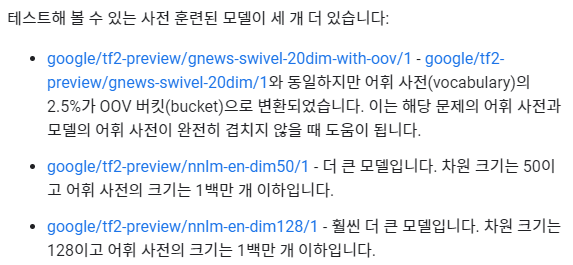

- 문장 임베딩을 위해 TF-Hub 모델을 사용하는 keras layer 를 만들어보자.
- 입력 텍스트 길이에 상관없이 임베딩 출력의 길이는 (num_examples, embedding_dimension)이 됨.

In [9]:
embedding = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1' # 이렇게만 해서 된다고 ㄷㄷ
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

    전체 모델을 구성해보자.

In [10]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


    이전과는 다르게 첫번째 층으로 hub_layer를 썼음.
    사전 훈련된 모델을 사용해 하나의 문장을 임베딩 벡터로 매핑.
        하나의 문장을 token단위로 나누고, 각 token의 임베딩을 연결해서 반환.

### Loss Function & Optimizer

<br>

- 이전과 동일하게 binary_crossentropy를 씁니당

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Training

In [12]:
with tf.device('/GPU:0'):
    history = model.fit(train_data.shuffle(10000).batch(512),
                        epochs=20,
                        validation_data=validation_data.batch(512),
                        verbose=1)

Epoch 1/20
30/30 [==============================] - 2s 68ms/step - loss: 0.7268 - accuracy: 0.5584 - val_loss: 0.6683 - val_accuracy: 0.5962
Epoch 2/20
30/30 [==============================] - 2s 54ms/step - loss: 0.6366 - accuracy: 0.6331 - val_loss: 0.6189 - val_accuracy: 0.6431
Epoch 3/20
30/30 [==============================] - 2s 54ms/step - loss: 0.5959 - accuracy: 0.6678 - val_loss: 0.5860 - val_accuracy: 0.6867
Epoch 4/20
30/30 [==============================] - 2s 54ms/step - loss: 0.5620 - accuracy: 0.6973 - val_loss: 0.5547 - val_accuracy: 0.7075
Epoch 5/20
30/30 [==============================] - 2s 59ms/step - loss: 0.5295 - accuracy: 0.7219 - val_loss: 0.5249 - val_accuracy: 0.7228
Epoch 6/20
30/30 [==============================] - 2s 57ms/step - loss: 0.4967 - accuracy: 0.7472 - val_loss: 0.4968 - val_accuracy: 0.7393
Epoch 7/20
30/30 [==============================] - 2s 60ms/step - loss: 0.4640 - accuracy: 0.7717 - val_loss: 0.4682 - val_accuracy: 0.7696
Epoch 8/20
30

In [13]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
    print('%s : %.3f' % (name, value))

49/49 - 1s - loss: 0.3207 - accuracy: 0.8584
loss : 0.321
accuracy : 0.858
